In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2021-bank-scoring-case-2/X_test.csv
/kaggle/input/2021-bank-scoring-case-2/y_train.csv
/kaggle/input/2021-bank-scoring-case-2/X_train.csv
/kaggle/input/2021-bank-scoring-case-2/y_test_sample.csv


In [74]:
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.cluster import KMeans

import optuna  # 
from optuna.integration import LightGBMPruningCallback
from tqdm import tqdm

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

Признаки одной заявки, которые есть в файлах X_train и X_test:

* age — возраст заемщика
* monthly_income — месячный доход заемщика
* credit_card_utilization — отношение баланса на счету к лимиту по кредиту
* debt_to_income — Соотношение долга к доходу
* credits_loans — текущее число займов и кредитных линий
* mortgage_loans — текущее количество ипотечных займов
* family_members — количество членов в семье заемщика
* overdue_30_59_days — число предыдущих просрочек выплат по кредиту от 30 до 59 дней
* overdue_60_89_days — число предыдущих просрочек выплат по кредиту от 60 до 89 дней
* overdue__more_than_90_days — число предыдущих просрочек выплат по кредиту более 90 дней
* target — была ли просрочки выплат по кредиту более 90 дней - имеется только в обучающей выборке

In [3]:
X_train = pd.read_csv('/kaggle/input/2021-bank-scoring-case-2/X_train.csv')
y_train = pd.read_csv('/kaggle/input/2021-bank-scoring-case-2/y_train.csv')
X_test = pd.read_csv('/kaggle/input/2021-bank-scoring-case-2/X_test.csv')
sample_submission = pd.read_csv('/kaggle/input/2021-bank-scoring-case-2/y_test_sample.csv')

In [4]:
X_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0


# EDA

Смотрю на распределения данных, в целом, в зависимости от класса, в зависимости от трейн/тест выборки, выявляю выбросы

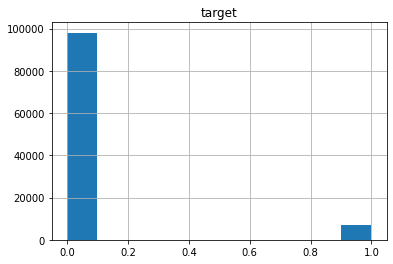

In [5]:
y_train.hist()
plt.show()

Датасет несбалансирован, надо будет попробовать это исправить.

credit_card_utilization


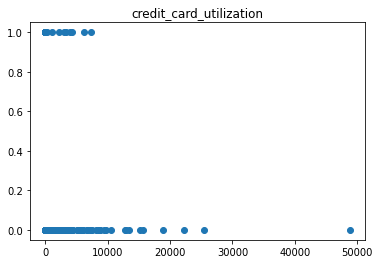

age


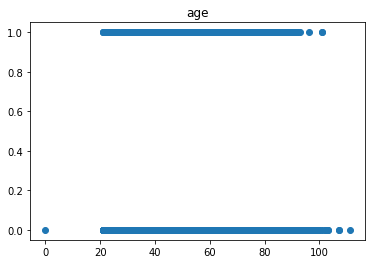

overdue_30_59_days


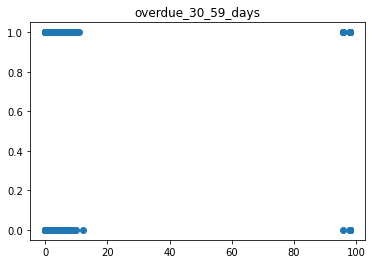

debt_to_income


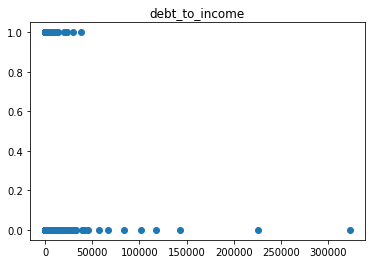

monthly_income


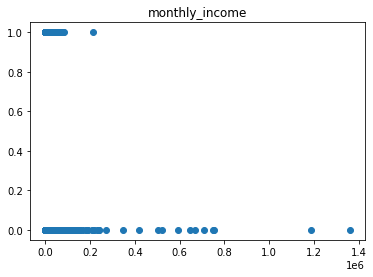

credits_loans


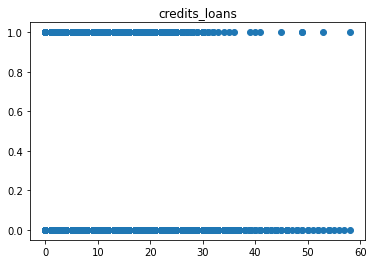

overdue__more_than_90_days


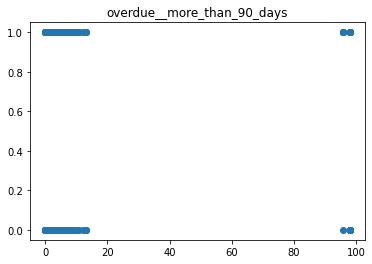

mortgage_loans


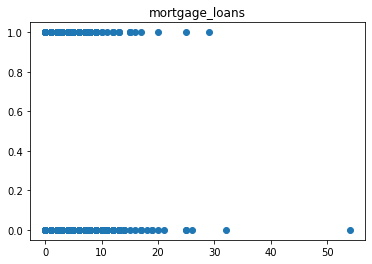

overdue_60_89_days


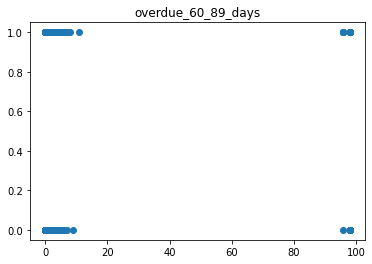

family_members


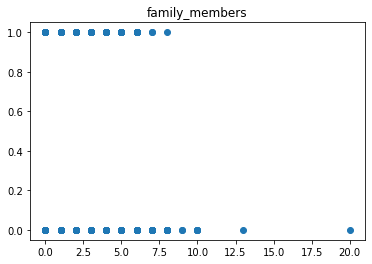

In [6]:
for i in X_train.columns:
    print(i)
    plt.scatter(X_train[i], y_train )
    plt.title(i)
    plt.show()

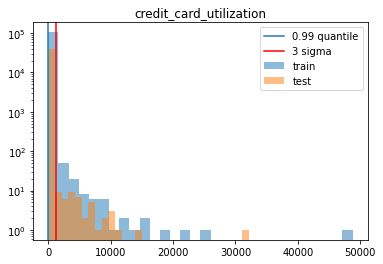

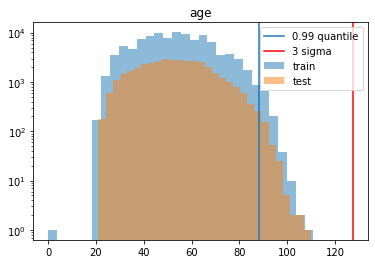

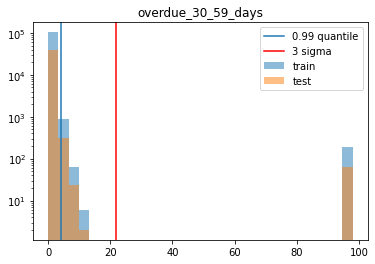

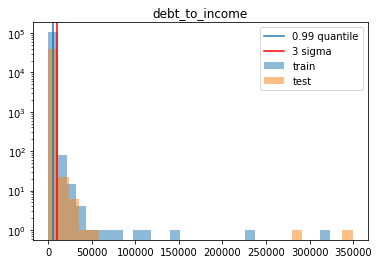

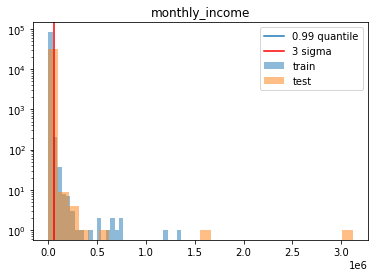

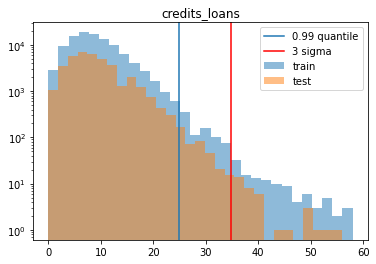

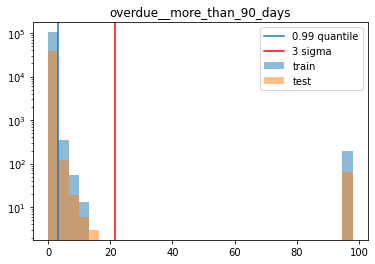

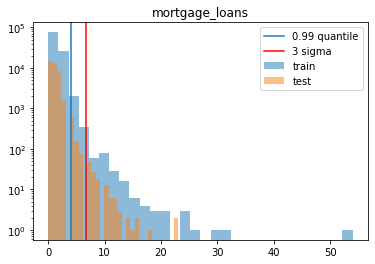

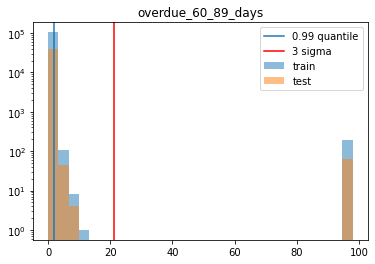

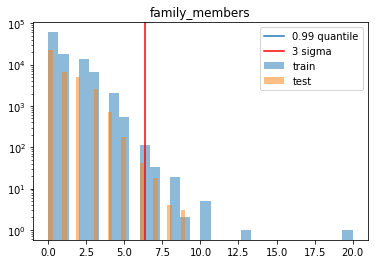

In [7]:
for i in X_train.columns:
    #sns.distplot(X_train[i], bins = 30, )
    plt.hist(X_train[i], bins = 30, alpha = 0.5, label = 'train')
    plt.hist(X_test[i], bins = 30, alpha = 0.5, label = 'test')
    plt.axvline(np.quantile(X_train[i], 0.99), label = '0.99 quantile')
    plt.axvline(np.mean(X_train[i]) + 5*np.std(X_train[i]), label = '3 sigma', c = 'r')
    plt.legend()
    plt.yscale('log')
    plt.title(i)
    plt.show()

In [8]:
train = pd.concat([X_train, y_train], axis = 1)
train_all = train[train.isnull().any(axis = 1) == False]

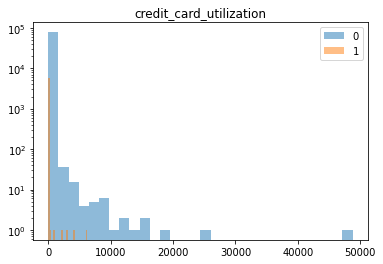

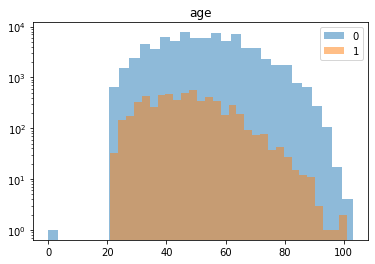

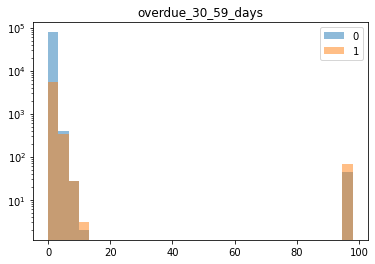

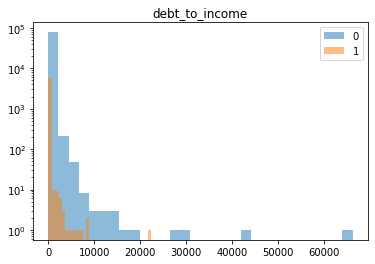

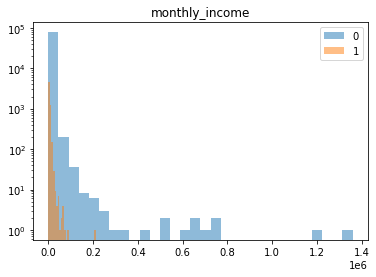

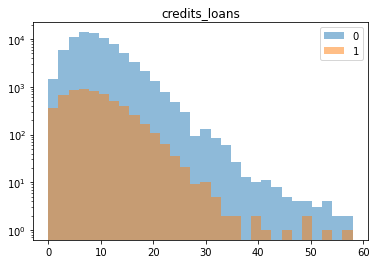

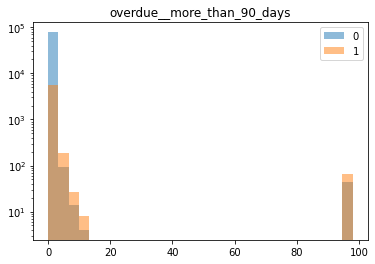

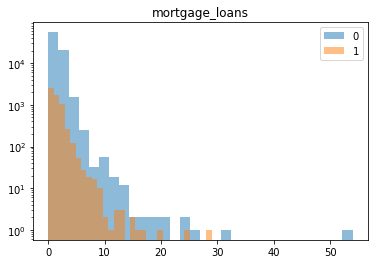

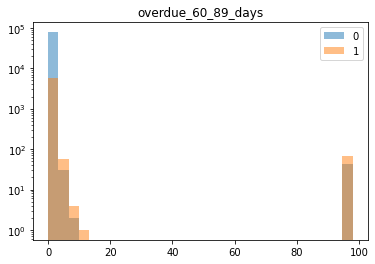

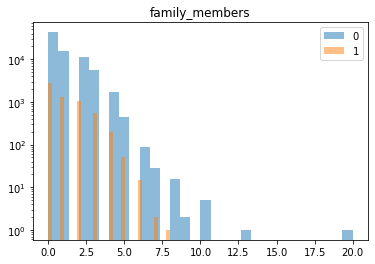

In [9]:
for i in X_train.columns:
    plt.hist(train_all[train_all.target == 0][i], bins = 30, label = '0', alpha = 0.5)
    plt.hist(train_all[train_all.target == 1][i], bins = 30, label = '1', alpha = 0.5)
    
    plt.yscale('log')
    plt.title(i)
    plt.legend()
    plt.show()

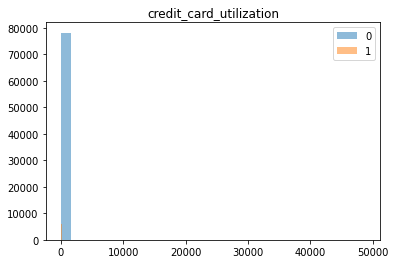

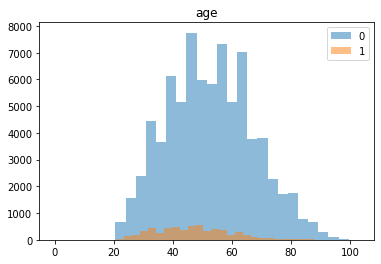

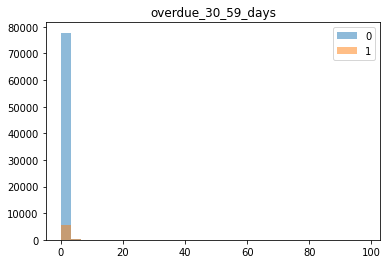

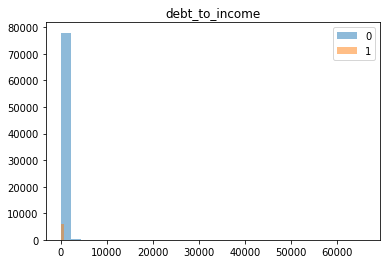

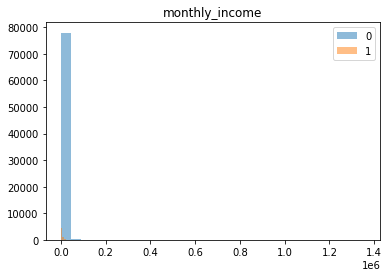

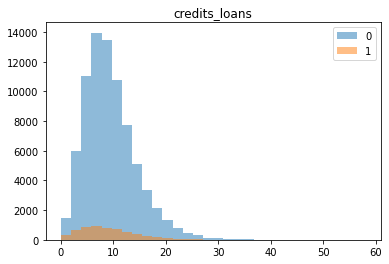

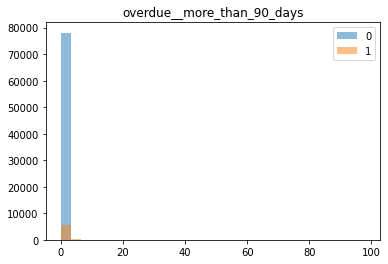

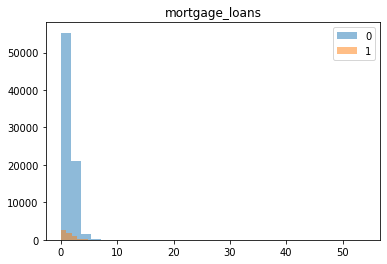

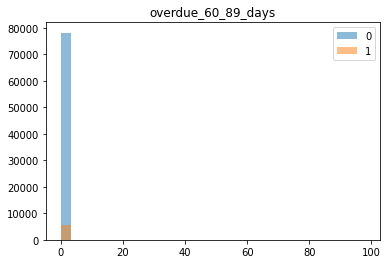

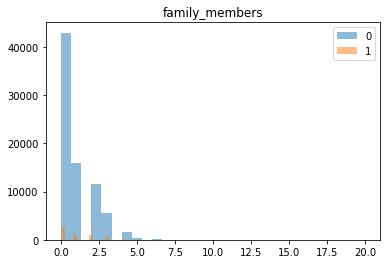

In [10]:
for i in X_train.columns:
    plt.hist(train_all[train_all.target == 0][i], bins = 30, label = '0', alpha = 0.5)
    plt.hist(train_all[train_all.target == 1][i], bins = 30, label = '1', alpha = 0.5)
    
    #plt.yscale('log')
    plt.title(i)
    plt.legend()
    plt.show()

In [11]:
X_train.isnull().sum()

credit_card_utilization           0
age                               0
overdue_30_59_days                0
debt_to_income                    0
monthly_income                20993
credits_loans                     0
overdue__more_than_90_days        0
mortgage_loans                    0
overdue_60_89_days                0
family_members                 2805
dtype: int64

In [12]:
X_train.shape

(105109, 10)

In [13]:
X_train.agg(max)

credit_card_utilization       4.877973e+04
age                           1.110000e+02
overdue_30_59_days            9.800000e+01
debt_to_income                3.232482e+05
monthly_income                1.359526e+06
credits_loans                 5.800000e+01
overdue__more_than_90_days    9.800000e+01
mortgage_loans                5.400000e+01
overdue_60_89_days            9.800000e+01
family_members                2.000000e+01
dtype: float64

In [14]:
pd.DataFrame(X_test.agg(max)).reset_index().merge(pd.DataFrame(X_train.agg(max)).reset_index(), how = 'right', on = 'index')

,index,0_x,0_y
0,credit_card_utilization,3.213106e+04,4.877973e+04
1,age,1.100000e+02,1.110000e+02
2,overdue_30_59_days,9.800000e+01,9.800000e+01
3,debt_to_income,3.494648e+05,3.232482e+05
4,monthly_income,3.117341e+06,1.359526e+06
5,credits_loans,5.600000e+01,5.800000e+01
6,overdue__more_than_90_days,9.800000e+01,9.800000e+01
7,mortgage_loans,2.300000e+01,5.400000e+01
8,overdue_60_89_days,9.800000e+01,9.800000e+01
9,family_members,9.000000e+00,2.000000e+01


98 - ?  

В колонках 'overdue_30_59_days', 'overdue__more_than_90_days', 'overdue_60_89_days' есть значения 98 и 96, которые сильно выбиваются из общего распределения и выглядят как выбросы.

<AxesSubplot:>

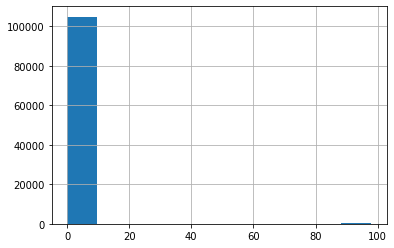

In [15]:
X_train.overdue__more_than_90_days.hist()

In [16]:
X_train.overdue__more_than_90_days.value_counts()

0     99322
1      3622
2      1086
3       461
4       209
98      189
5        99
6        48
7        24
8        18
9        13
96        5
13        4
10        4
11        3
12        2
Name: overdue__more_than_90_days, dtype: int64

In [17]:
print(X_train.overdue__more_than_90_days.unique())
X_test.overdue__more_than_90_days.unique()

[ 0  1  4  2  3 98  5  6  7  9  8 13 96 11 10 12]


array([ 0,  1, 98,  2,  3,  5,  6,  4, 11,  9,  7, 14,  8, 10, 15])

In [18]:
print(X_train[X_train.age > 100].shape)
print(X_test[X_test.age > 100].shape)

(10, 10)
(5, 11)


In [ ]:
# Замена таких значений на макисимальное адекватное значение
for i in ['overdue_30_59_days', 'overdue__more_than_90_days', 'overdue_60_89_days']:
    X_train[i].replace(98, 12, inplace = True)
    X_train[i].replace(96, 12, inplace = True)
    X_test[i].replace(98, 12, inplace = True)
    X_test[i].replace(96, 12, inplace = True)

# Feature Engeneering

Добавить возрастные группы

In [21]:
# Заолнить пропуски медианой
X_train['family_members'] = X_train['family_members'].fillna(np.median(train_all['family_members']))
X_test['family_members'] =  X_test['family_members'].fillna(np.median(train_all['family_members']))

In [22]:
def create_age_groups(X, age_column_name):
    def choose_group(y):
        for i, j in zip([[-1,30], [30,40], [40,50], [50,60], [60,70], [70,80], [80, 10000]], [1,2,3,4,5,6,7]):
            if i[0] <= y < i[1]:
                return j
    X['age_groups'] = X[age_column_name].apply(lambda x : choose_group(x))
    return X

X_train = create_age_groups(X_train, 'age')
X_test = create_age_groups(X_test, 'age')

In [23]:
X_train.isnull().sum()

credit_card_utilization           0
age                               0
overdue_30_59_days                0
debt_to_income                    0
monthly_income                20993
credits_loans                     0
overdue__more_than_90_days        0
mortgage_loans                    0
overdue_60_89_days                0
family_members                    0
age_groups                        0
dtype: int64

Заполнить пропуски

In [24]:
X_train['monthly_income'].fillna(0, inplace=True)
X_test['monthly_income'].fillna(0, inplace = True)

В ходе моделирования выявил, что самые важные признаки - credit_card_utilization и debt_to_income, поэтому создаю новые фичи с ними чтобы учесть возможную нелинейность - квадрат и логарифм

In [25]:
X_train['pow_ccu'] = X_train['credit_card_utilization'].apply(lambda x : x**2 )
X_test['pow_ccu'] = X_test['credit_card_utilization'].apply(lambda x : x**2 )

X_train['log_ccu'] = X_train['credit_card_utilization'].apply(lambda x : np.log(1+x) )
X_test['log_ccu'] = X_test['credit_card_utilization'].apply(lambda x : np.log(1+x) )

In [26]:
X_train['pow_di'] = X_train['debt_to_income'].apply(lambda x : x**2 )
X_test['pow_di'] = X_test['debt_to_income'].apply(lambda x : x**2 )

X_train['log_di'] = X_train['debt_to_income'].apply(lambda x : np.log(1+x) )
X_test['log_di'] = X_test['debt_to_income'].apply(lambda x : np.log(1+x) )

In [27]:
X_train.columns

Index(['credit_card_utilization', 'age', 'overdue_30_59_days',
       'debt_to_income', 'monthly_income', 'credits_loans',
       'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_89_days',
       'family_members', 'age_groups', 'pow_ccu', 'log_ccu', 'pow_di',
       'log_di'],
      dtype='object')

Scale

In [28]:
num_cols = ['credit_card_utilization', 'debt_to_income', 'monthly_income', 'age', 'credits_loans', 'pow_ccu', 'log_ccu',
            'pow_di', 'log_di']
cat_cols = ['overdue_30_59_days', 'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_89_days', 'family_members', 'age_groups']

In [29]:
sc = StandardScaler()
X_train_num = sc.fit_transform(X_train[num_cols])
X_test_num = sc.transform(X_test[num_cols])

In [30]:
X_train_num = pd.DataFrame(X_train_num) 
X_test_num = pd.DataFrame(X_test_num) 
X_test_num.columns = num_cols
X_train_num.columns = num_cols

In [31]:
X_train = pd.concat([X_train_num, X_train[cat_cols]], axis = 1)
X_test = pd.concat([X_test_num, X_test[cat_cols]], axis = 1)

Попытка кластеризации клиентов и добавление кластера как новая фича

In [33]:
wcss = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_train.replace(np.NaN, 0))
    wcss.append(kmeans.inertia_)

plt.plot(range(1,20), wcss)



In [34]:
kmeans = KMeans(n_clusters=12)
kmeans.fit(X_train)

clstrs = kmeans.predict(X_train)
clstrs_y = kmeans.predict(X_test)

X_train['clst'] = clstrs
X_test['clst'] = clstrs_y

Еще одна фича - суммарное количество всех просрочек

In [35]:
X_train['all_overdues'] = X_train[['overdue__more_than_90_days', 'overdue_30_59_days', 'overdue_60_89_days']].sum(axis = 1)
X_test['all_overdues'] = X_test[['overdue__more_than_90_days', 'overdue_30_59_days', 'overdue_60_89_days']].sum(axis = 1)

In [36]:
X_train.columns

Index(['credit_card_utilization', 'debt_to_income', 'monthly_income', 'age',
       'credits_loans', 'pow_ccu', 'log_ccu', 'pow_di', 'log_di',
       'overdue_30_59_days', 'overdue__more_than_90_days', 'mortgage_loans',
       'overdue_60_89_days', 'family_members', 'age_groups', 'clst',
       'all_overdues'],
      dtype='object')

In [37]:
old_columns = ['credit_card_utilization', 'age', 'overdue_30_59_days','debt_to_income', 'monthly_income', 'credits_loans',
       'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_89_days',
       'family_members']

In [38]:
X_train.head()

,credit_card_utilization,debt_to_income,monthly_income,age,credits_loans,pow_ccu,log_ccu,pow_di,log_di,overdue_30_59_days,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,age_groups,clst,all_overdues
0,-0.023206,-0.193569,0.146575,0.180875,0.008441,-0.007877,-0.668681,-0.00937,-0.427168,0,0,1,0,5.0,4,6,0
1,-0.022526,-0.192528,-0.484425,-0.561819,-0.763359,-0.007877,-0.259280,-0.00937,-0.116914,1,0,0,0,0.0,3,4,1
2,-0.021843,-0.193601,1.466275,1.463711,0.008441,-0.007877,0.095970,-0.00937,-0.442428,1,0,3,0,0.0,6,2,1
3,-0.023022,-0.193399,-0.236819,-0.224231,0.587291,-0.007877,-0.551284,-0.00937,-0.355991,0,0,1,0,3.0,4,6,0
4,-0.020499,-0.193631,1.903703,0.315911,1.166141,-0.007877,0.678600,-0.00937,-0.457094,0,0,4,0,2.0,4,2,0


# Models

In [39]:
X_train['family_members'] = X_train['family_members'].apply(lambda x: int(x))
X_test['family_members'] = X_test['family_members'].apply(lambda x: int(x))

## Линейные модели

In [53]:
from sklearn.linear_model import LogisticRegressionCV

In [56]:
# проверим качество линейной регрессии на кросс-валидации

train_scores = []
val_scores = []
models = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = LogisticRegressionCV(solver='liblinear', cv=3, n_jobs = -1).fit(X_tr,y_tr)
    val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    train_scores.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
    models.append(model)

print('val mean: ', np.mean(val_scores))
print('train mean: ', np.mean(train_scores))

val mean:  0.8044359423590072
train mean:  0.8048670914729226


## RandomForest, LightGBM, XGBoost

In [57]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
def train_validate_model(model, X, y):
    train_scores = []
    val_scores = []
    models = []
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        model = model.fit(X_tr,y_tr)
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
        train_scores.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
        models.append(model)
        
    print('val mean: ', np.mean(val_scores))
    print('train mean: ', np.mean(train_scores))

In [64]:
for model_name in [RandomForestClassifier(n_estimators=500), LGBMClassifier(), XGBClassifier()]:
    print(model_name.__class__.__name__)
    train_validate_model(model_name, X_train, y_train)

RandomForestClassifier
val mean:  0.8447773332720968
train mean:  0.9999999994562704
LGBMClassifier
val mean:  0.8609451202105131
train mean:  0.9122133454690137
XGBClassifier
[16:42:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
val mean:  0.8521941163699259
train mean:  0.932149096113145


## CatBoost

Буду работать в дальнейшем именно с ним, так дает лушее качество и меньше переобучается при этом

In [69]:
# валидация для CatBoost, возвращает ансамбль из моделей обученный на разных фолдах
def train_validate_cb(X, y, params = {}):
    params['verbose'] = 0
    train_scores = []
    val_scores = []
    models = []
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        model = cb.CatBoostClassifier(**params).fit(X_tr,y_tr, eval_set=(X_val, y_val), early_stopping_rounds=10, use_best_model=True)
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
        train_scores.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
        models.append(model)
        
    print('val mean: ', np.mean(val_scores))
    print('train mean: ', np.mean(train_scores))
    return models


In [70]:
models = train_validate_cb(X_train, y_train)

val mean:  0.8640844085543847
train mean:  0.8699198062411204


In [71]:
# Важность признаков, из аггрегированных моделей
def plot_importaces_cb(models):
    imptances = np.mean([i.get_feature_importance() for i in models], axis = 0)
    imptances = imptances/sum(imptances) * 100
    imps = sorted([*zip(models[0].feature_names_, imptances)], reverse = True, key=lambda x: x[1])
    axis_font = {'size':'16'}

    colormap = plt.cm.get_cmap('viridis') # 'plasma' or 'viridis'
    colors = colormap([x[1]/35 for x in imps])
    plt.figure(figsize = (15, 10), )
    plt.bar([x[0] for x in imps], [x[1] for x in imps], color = colors, )
    plt.gca().set_xticklabels([x[0] for x in imps], rotation=60, horizontalalignment= 'right')
    plt.ylabel('Importance, percents', **axis_font)
    plt.xlabel('Features', **axis_font)
    plt.show()


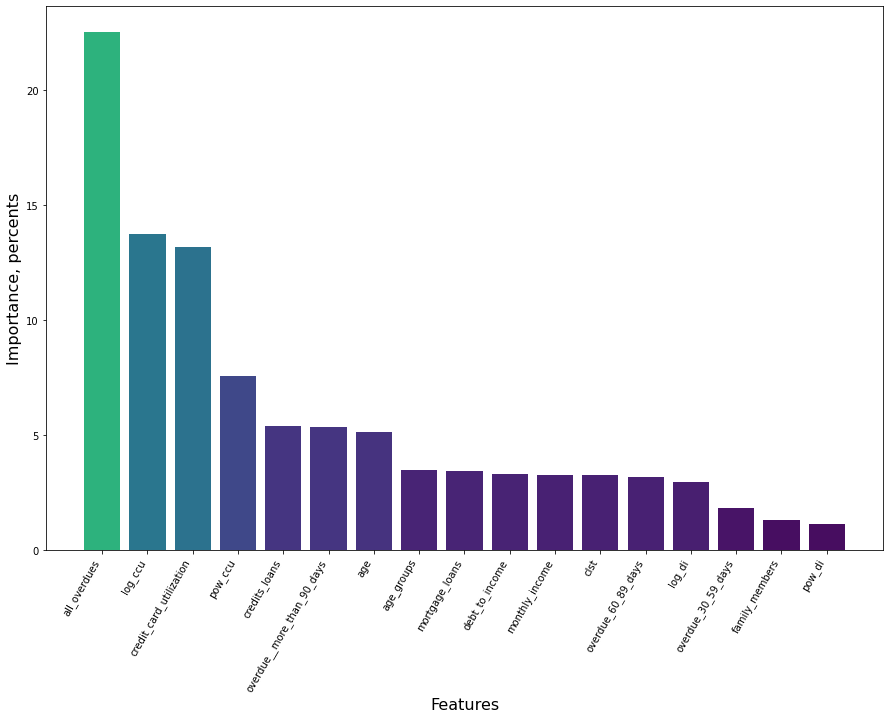

In [72]:
plot_importaces_cb(models)

Пробовал делать traget_encoding для категориальных фичей, прироста от этого не было, так что в итоге не использовал

In [ ]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


In [ ]:
for i in cat_cols:
    X_train[f'{i}_encoded'], X_test[f'{i}_encoded'] = target_encode(X_train[i], X_test[i], 
                                                                target=y_train['target'], 
                                                                min_samples_leaf=100,
                                                                smoothing=10,
                                                                noise_level=0.01)

### Попытка избавиться от дизбаланса классов
Сначала пробовал upsampling, сработало не очень, далее реализовал downsampling, это сработало лучше

In [75]:
train_cols = X_train.columns

In [76]:
def upsample_train_validate_cb(X, y, params = {}):
    params['verbose'] = 0
    train_scores = []
    val_scores = []
    models = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        train_val = pd.concat([pd.DataFrame(X_tr), pd.DataFrame(y_tr)], axis = 1)
        append = train_val[train_val.target == 1]
        for _ in range(5):
            train_val = pd.concat([train_val, append])
        train_val = train_val.sample(frac = 1)
        
        
        
        model = cb.CatBoostClassifier(**params).fit(train_val[train_cols],train_val[train_val.columns[-1]], eval_set=(X_val, y_val), early_stopping_rounds=10, use_best_model=True)
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
        train_scores.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
        models.append(model)
        
    print('val mean: ', np.mean(val_scores))
    print('train mean: ', np.mean(train_scores))
    return models

In [77]:
upsample_train_validate_cb(X_train[train_cols], y_train)

val mean:  0.8498740596008814
train mean:  0.9363929443622293


In [78]:
def downsample_train_validate_cb(X, y, params = {}):
    params['verbose'] = 0
    train_scores = []
    val_scores = []
    models = []
    cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    
    for idx, (train_idx, test_idx) in tqdm(enumerate(cv.split(X, y))):
        X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        train_val = pd.concat([pd.DataFrame(X_tr), pd.DataFrame(y_tr)], axis = 1)
        ones = train_val[train_val.target == 1]
        train_val = pd.concat([ones, train_val[train_val.target == 0].sample(n= 5*ones.shape[0])])
        
               
        model = cb.CatBoostClassifier(**params).fit(train_val[train_cols],train_val[train_val.columns[-1]], eval_set=(X_val, y_val), early_stopping_rounds=10, use_best_model=True)
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
        train_scores.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
        models.append(model)
        
    print('val mean: ', np.mean(val_scores))
    print('train mean: ', np.mean(train_scores))
    return models

In [79]:
models1 = downsample_train_validate_cb(X_train[train_cols], y_train)

20it [00:31,  1.56s/it]

val mean:  0.8646148318222899
train mean:  0.8702358618944757


In [ ]:
# параметры подобранные optuna, фнукция для подбора в самом конце ноутбука
b_params = {'learning_rate': 0.06723964861272881, 'iterations': 800, 'colsample_bylevel': 0.09312788959812679, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 28.36662267508364, 'subsample': 0.9696811172318005}
# Просто катбуст на всех данных
cb = cb.CatBoostClassifier(**b_params).fit(X_train, y_train)

В лучшем предсказании использовал ансамбль из:
1. Отдельная модель на всех данных
2. Ансамбль моделей с валидации 
3. Ансамбль моделей с валидации + downsamplig

In [ ]:
preds1 = cb.predict_proba(X_test[train_cols])[:, 1]

preds2 = []
for model in models:
    preds2.append(model.predict_proba(X_test[train_cols])[:, 1])
preds2= np.mean(preds2, axis = 0)

preds3 = []
for model in models1:
    preds3.append(model.predict_proba(X_test[train_cols])[:, 1])
preds3 = np.mean(preds3, axis = 0)

In [ ]:
preds =(preds1 + preds2 + preds3 )/3

In [ ]:
sample_submission.target = preds
sample_submission

In [ ]:
sample_submission.to_csv('test_subm_f.csv', index = False)

### with Focal Loss

Пробовал учить с использованием Focal Loss (как будто должно лучше работать если есть дисбаланс классов), но у меня не сработало

In [ ]:
import math
from six.moves import xrange
from catboost import Pool, CatBoostClassifier


class FocalLossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers with only __len__ and __getitem__ defined).
        # weights parameter can be None.
        # Returns list of pairs (der1, der2)
        gamma = 2.
        # alpha = 1.
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        exponents = []
        for index in xrange(len(approxes)):
            exponents.append(math.exp(approxes[index]))

        result = []
        for index in xrange(len(targets)):
            p = exponents[index] / (1 + exponents[index])

            if targets[index] > 0.0:
                der1 = -((1-p)**(gamma-1))*(gamma * math.log(p) * p + p - 1)/p
                der2 = gamma*((1-p)**gamma)*((gamma*p-1)*math.log(p)+2*(p-1))
            else:
                der1 = (p**(gamma-1)) * (gamma * math.log(1 - p) - p)/(1 - p)
                der2 = p**(gamma-2)*((p*(2*gamma*(p-1)-p))/(p-1)**2 + (gamma-1)*gamma*math.log(1 - p))

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))

        return result



#if __name__ == '__main__':

"""
    # Initialize CatBoostClassifier with custom `loss_function`
    model = CatBoostClassifier(loss_function=FocalLossObjective(),
                            eval_metric="Logloss")
    # Fit model
    model.fit(train_data, train_labels)
    # Only prediction_type='RawFormulVal' allowed with custom `loss_function`
    preds_raw = model.predict(eval_data,
                            prediction_type='RawFormulaVal')
"""

In [ ]:
def train_validate_cb_fl(X, y, params = {}):
    params['verbose'] = 0
    train_scores = []
    val_scores = []
    models = []
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        model = cb.CatBoostClassifier(**params).fit(X_tr,y_tr, eval_set=(X_val, y_val), early_stopping_rounds=10, use_best_model=True)
        val_scores.append(roc_auc_score(y_val, model.predict(X_val, prediction_type='RawFormulaVal')))
        train_scores.append(roc_auc_score(y_tr, model.predict(X_tr, prediction_type='RawFormulaVal')))
        models.append(model)
        
    print('val mean: ', np.mean(val_scores))
    print('train mean: ', np.mean(train_scores))
    return models

In [ ]:
models = train_validate_cb_fl(X_train, y_train, {'loss_function' : FocalLossObjective(), 'eval_metric': 'Logloss'})

### Подбор гипперпараметров для катбуста

In [ ]:
def objective(trial, X, y):
    param = {
        "objective": 'Logloss',
        "verbose" : 0,
        #"task_type": "GPU",
        #"devices" : "0:1",
        #"cat_features" : [9,10,11],
        "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.3),
        "iterations" : trial.suggest_int("iterations", 400, 1000, step = 50), 
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 0.001, 30),
        "used_ram_limit": "10gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    cv_scores = np.empty(10)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        #X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        #y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        train_val = pd.concat([pd.DataFrame(X_tr), pd.DataFrame(y_tr)], axis = 1)
        ones = train_val[train_val.target == 1]
        train_val = pd.concat([ones, train_val[train_val.target == 0].sample(n= 3*ones.shape[0])])

        model = cb.CatBoostClassifier(**param)
        model.fit(
            train_val[train_cols],
            train_val[train_val.columns[-1]],
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            use_best_model=True
        )
        preds = model.predict_proba(X_val)[:, 1]
        cv_scores[idx] = roc_auc_score(y_val, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="CatBoostClassifier")
func = lambda trial: objective(trial, X_train[train_cols], y_train)
study.optimize(func, n_trials=250)

print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

study.best_params

In [ ]:
 best_params = {'learning_rate': 0.10142933805423604,
                 'iterations': 750,
                 'colsample_bylevel': 0.09662488192925815,
                 'depth': 8,
                 'boosting_type': 'Ordered',
                 'bootstrap_type': 'MVS',
                 'l2_leaf_reg': 6.186007780263872}